# Aktivitätsbestimmung durch Beschleunigung und Drehrate
Dieses Notebook beschäftigt sich mit der Klassifizierung von Aktivitätszuständen einer Person mithilfe von Recurrent
Neural Networks (kurz RNN). Der verwendete Datensatz ist über den untenstehenden Link verfügbar und beinhaltet
Aufnahmen mit sechs verschiedenen Aktivitätszuständen, die entsprechend gelabelt sind. Dabei werden zunächst Trainings-
und Testdatensatz geladen und in eine für das Training nutzbare Form transformiert. Anschließend wird darauf ein RNN
trainiert die Ergebnisse evaluiert.

Datensatz verfügbar unter: https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip

Der Ordner _UCI HAR Dataset_ sollte im gleichen Verzeichnis liegen wie dieses Notebook.

## Import der benötigten Pakete

In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras

## Erster Einblick in den Datensatz
Im ersten Schritt soll ein Grundverständnis für die Daten erzeugt werden. Die Struktur der Daten ist auf den
ersten Blick nicht direkt ersichtlich und wird daher kurz erklärt.

Bei der Erhebung wurden sowohl Beschleunigungssensor als auch Gyroskope mit drei Achsen verwendet, was auch jeweils im
Ordner *Inertial_Signals* in _test_ und _train_ wiederzufinden ist. Die Beschleunigungsdaten enthalten die
Erdbeschleunigung und wurden mit einem Low-Pass-Filter in absolute Beschleunigung und körpereigene Beschleunigung
unterteilt (*body_acc* & *total_acc*). In den einzelnen Dateien liegen die Messungen bereits als getrennte Zeitreihen
vor, d. h. jede Zeile steht für eine einzelne Instanz und enthält jeweils 128 Messwerte. Somit ergeben sich für jede
zusammenhängende Instanz neun Features mit jeweils 128 Messwerten.

An dieser Stelle soll zunächst die Verteilung der verschiedenen Aktivitätstypen der Daten näher untersucht werden (nach
dem Laden des Datensatzes werden einzelne Instanzen verschiedener Klassen visualisiert), da diese beim maschinellen eine
wichtige Rolle spielen kann. Die Labels werden aus den entsprechenden Dateien geladen und als Balkendiagramm dargestellt.
Die Bezeichnungen der einzelnen Aktivitäten können der Datei *activity_labels.txt* entnommen werden.

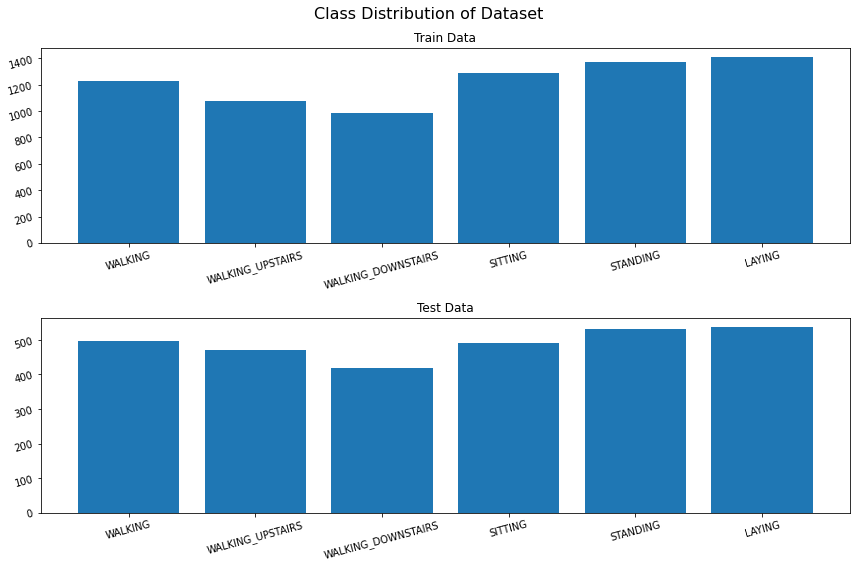

In [2]:
# Set the path to training and test data & set label names
TRAIN_PATH = pathlib.Path('UCI HAR Dataset/train')
TEST_PATH = pathlib.Path('UCI HAR Dataset/test')
LABELS = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

# Load labels
train_labels = pd.read_csv(os.path.join(TRAIN_PATH, 'y_train.txt')).to_numpy().squeeze()
test_labels = pd.read_csv(os.path.join(TEST_PATH, 'y_test.txt')).to_numpy().squeeze()

# Create distribution plots
fig, axs = plt.subplots(2)
fig.suptitle('Class Distribution of Dataset', fontsize=16)
fig.set_size_inches(12, 8)
axs[0].bar(LABELS, np.unique(train_labels, return_counts=True)[1])
axs[0].set(title='Train Data')
axs[0].tick_params(labelrotation=15)
axs[1].bar(LABELS, np.unique(test_labels, return_counts=True)[1])
axs[1].set(title='Test Data')
axs[1].tick_params(labelrotation=15)
plt.tight_layout()
plt.show()

## Daten einlesen und transformieren
Um den folgenden Code gut nachvollziehen zu können, ist ein Verständis zum Aufbau der Datenstruktur unerlässlich. Wie
bereits genannt, liegen in den einzelnen Dateien Zeitreihen der verschiedenen Sensoren vor, die beim Laden der Daten
zusammengebracht werden müssen. So müssen z. B. jeweils die ersten Zeilen verbunden werden, sodass eine Matrix der
Form 128 × 9 entsteht.

Die untenstehende Funktion lädt jeweils für den Trainings- sowie den Testdatensatz die einzelnen Dateien in einen
DataFrame (`sep='\s+'` für mehrere Leerzeichen als Abtrennung) und hängt diesen als Matrix in Form eines Numpy Arrays an
eine Liste an. Durch die Anweisung `np.transpose(np.array(signals), (1, 2, 0))` werden die Dimensionen der Liste
vertauscht, dass die gewünschten 128 × 9 Matrizen entstehen. Das Einlesen der Labels ist etwas simpler, da die
Datei nur ein Label pro Zeile enthält. Über `.squeeze()` werden 1-dimensionale Einträge aus der Form entfernt, um die
Daten in die richtige Form zu bringen.

__Anmerkung:__ Die benötigte Form der Daten ist meist nicht direkt ersichtlich und ergibt sich meist mit der Zeit, wenn
Modelle erstellt und trainiert werden sollen.

In [3]:
def load_data_from_directory(data_path: pathlib.Path):
    print(f'Loading data from directory "{data_path}"')
    # Load signals / features
    signals = []
    signals_path = os.path.join(data_path, 'Inertial Signals')
    for signal_name in tqdm(os.listdir(signals_path)):
        signal_data = pd.read_csv(os.path.join(signals_path, signal_name), sep='\s+')
        signals.append(signal_data.to_numpy(dtype=np.float32))
    # Load labels and shift them by 1 to have easier indexing when checking description in LABELS
    labels_filename = 'y_train.txt' if os.path.exists(os.path.join(data_path, 'y_train.txt')) else 'y_test.txt'
    labels = pd.read_csv(os.path.join(data_path, labels_filename)).to_numpy().squeeze() - 1
    # Return transposed features and labels as Numpy arrays
    return np.transpose(np.array(signals), (1, 2, 0)), labels

# Load train and test data from corresponding directories
X_train, y_train = load_data_from_directory(data_path=TRAIN_PATH)
X_test, y_test = load_data_from_directory(data_path=TEST_PATH)

print(f'Shapes of train data are {X_train.shape} for X and {y_train.shape} for y.')
print(f'Shapes of test data are {X_test.shape} for X and {y_test.shape} for y.')

  0%|          | 0/9 [00:00<?, ?it/s]

Loading data from directory "UCI HAR Dataset\train"


  0%|          | 0/9 [00:00<?, ?it/s]

Loading data from directory "UCI HAR Dataset\test"


100%|██████████| 9/9 [00:03<00:00,  2.75it/s]

Shapes of train data are (7351, 128, 9) for X and (7351,) for y.
Shapes of test data are (2946, 128, 9) for X and (2946,) for y.


## Visualisierung einzelner Instanzen
Um ein besseres Verständnis für die Daten zu bekommen, mit denen nachfolgend das Modell trainiert werden soll, werden
zufällige Instanzen (Zeitreihen der Features) ausgewählt und visualisiert.

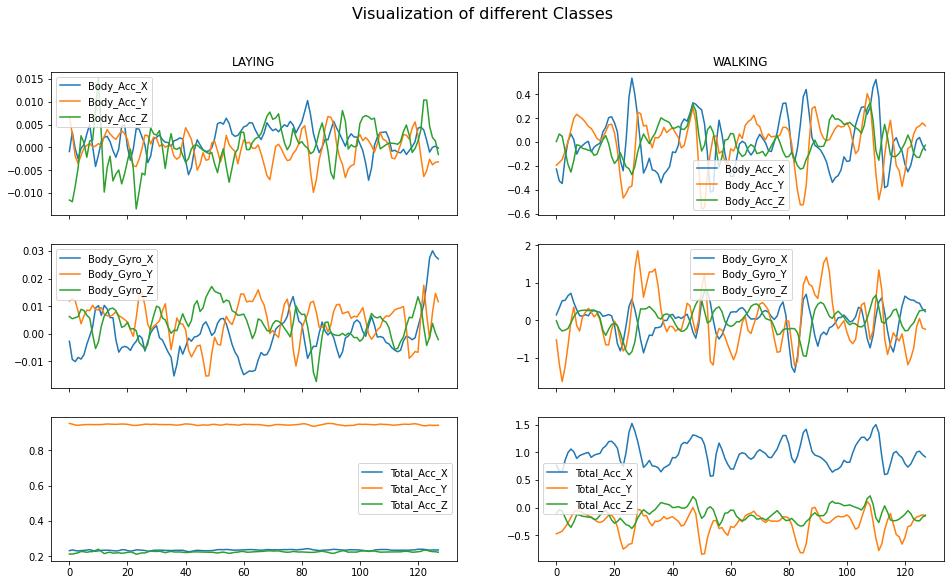

In [44]:
# Set classes to visualize and set the feature names
FEATURE_NAMES = ['Body_Acc_X', 'Body_Acc_Y', 'Body_Acc_Z',
                 'Body_Gyro_X', 'Body_Gyro_Y', 'Body_Gyro_Z',
                 'Total_Acc_X', 'Total_Acc_Y', 'Total_Acc_Z']
CLASSES = ['LAYING', 'WALKING']

fig, axs = plt.subplots(nrows=3, ncols=len(CLASSES), sharex=True, sharey=False)
fig.suptitle('Visualization of different Classes', fontsize=16)
fig.set_size_inches(16, 9)
x = np.arange(128)
for index, cls in enumerate(CLASSES):
    # Set class as label for top subplot of each column
    axs[0][index].set(title=cls)
    # Get random instance from training data with corresponding class
    instance_index = np.random.choice(np.argwhere(y_train==LABELS.index(cls)).flatten())
    instance = X_train[instance_index]
    # Plot the feature groups (all axis of one measurement) in the different subplots and add labels
    for sublot in [0, 1, 2]:
        axs[sublot][index].plot(x, instance[:, sublot*3])
        axs[sublot][index].plot(x, instance[:, sublot*3+1])
        axs[sublot][index].plot(x, instance[:, sublot*3+2])
        axs[sublot][index].legend(FEATURE_NAMES[sublot*3:sublot*3+3])
plt.show()

## Modell Architektur
Nachdem die Daten fertig vorbereitet sind, muss im nächsten Schritt die Architektur bzw. der Aufbau des neuronalen
Netzes festgelegt werden. Mithilfe der Keras Sequential-API können die einzelnen Schichten nacheinander festgelegt
werden.
1. Input Layer: In der ersten Schicht wird lediglich festgelegt, welche Form die eingehenden Daten haben. Dies muss
nicht zwingend als eigene Schicht eingegeben werden, sondern kann auch bei der nachfolgenden Schicht definiert werden.
2. RNN Layer: Die nächsten beiden Schichten sind das eigentliche RNN und verantwortlich für die Erkennung von Mustern
in den Daten, die das Netz durchlaufen. Beide Schichten enthalten 128 Zellen und nutzen die _relu_ Aktivierungsfunktion.
Die erste Schicht gibt allerdings im Gegensatz zur zweiten Schicht Sequenzen weiter, während die zweite nur das Ergebnis
der letzten Zelle ausgibt (_Many-To-Many_ vs. _Many-To-One_). Der verwendete Typ sind _SimpleRNN_ Zellen, die der
grundlegende Typ sind. Alternativ können _LSTM_ oder _GRU_ verwendet werden, die je nach Komplexität der Aufgabe bessere
Ergebnisse erzielen können, jedoch länger im Training brauchen.
3. Dense Layers: Abschließend beinhaltet das Netz ein Dense Layer mit 6, also den eigentlichen Klassifikator (ein Neuron
pro Klasse). Durch die Softmax Aktivierungsfunktion werden Werte zwischen 0 und 1 ausgegeben, die als Wahrscheinlichkeit
für die einzelnen Klassen gesehen werden können.

In [24]:
model = keras.Sequential(layers=[
        keras.layers.InputLayer(input_shape=X_train[0].shape),
        keras.layers.SimpleRNN(units=128, activation='relu', return_sequences=True),
        keras.layers.SimpleRNN(units=128, activation='relu', return_sequences=False),
        keras.layers.Dense(6, activation=keras.activations.softmax)
    ])
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 128, 128)          17664     
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 51,334
Trainable params: 51,334
Non-trainable params: 0
_________________________________________________________________
None


## Trainieren des Modells
Bevor das Modell trainiert werden kann, müssen noch die Labels kodiert werden. Wie im letzten Schritt festgelegt,
enthält die letzte Schicht des Netzes 6 Neuronen, wodurch die Ausgabe ein Vektor der Länge 6 ist. Die Labels liegen
momentan noch als Zahl in einem Vektor vor. Mithilfe des sogenannten One-Hot_Encodings können die Labels in Vektoren der
Länge 6 umgewandelt werden.

Während des Trainings werden 30 % der Daten zur Validierung des Trainingsfortschritts verwendet, um bei Bedarf durch
Callbacks eine Überanpassung an die Trainingsdaten zu vermeiden.

Nach dem Training können die Ergebnisse der Historie über die einzelnen Epochen hinweg visualisert werden.

Epoch 1/20
11/11 [==============================] - 5s 478ms/step - loss: 0.4871 - accuracy: 0.7878 - val_loss: 0.8064 - val_accuracy: 0.7643
Epoch 2/20
11/11 [==============================] - 5s 437ms/step - loss: 0.3963 - acc

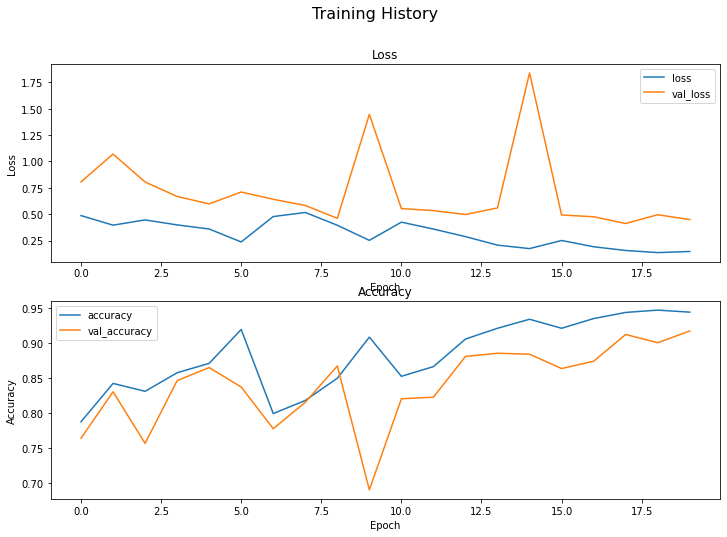

In [26]:
# Set parameters for data splitting and training
TEST_SIZE = 0.3
BATCH_SIZE = 512
EPOCHS = 20

# Encode the labels using One-Hot-Encoding
y_train_encoded = tf.one_hot(indices=y_train, depth=6)

# Train model using validation split
history = model.fit(x=X_train, y=y_train_encoded, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Plot the training histroy
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

## Evaluieren des Modells
Nach dem Training kann mithilfe der Testmenge, die das Modell bisher nicht gesehen hat, die Genauigkeit auf neuen Daten
ermittelt werden. Diese zeigt an, ob Overfitting oder Underfitting vorliegt, oder das Training ein gutes Ergebnis
erreicht hat.

Die Ergebnisse der Vorhersage können in einer Konfusions-Matrix dargestellt werden. Diese zeigt an, welche Klasse eine
Aufnahme wirklich hat und welche Klasse das Modell vorhergesagt hat. In der Hauptdiagonalen sind dabei die richtigen
Vorhersagen zu finden.

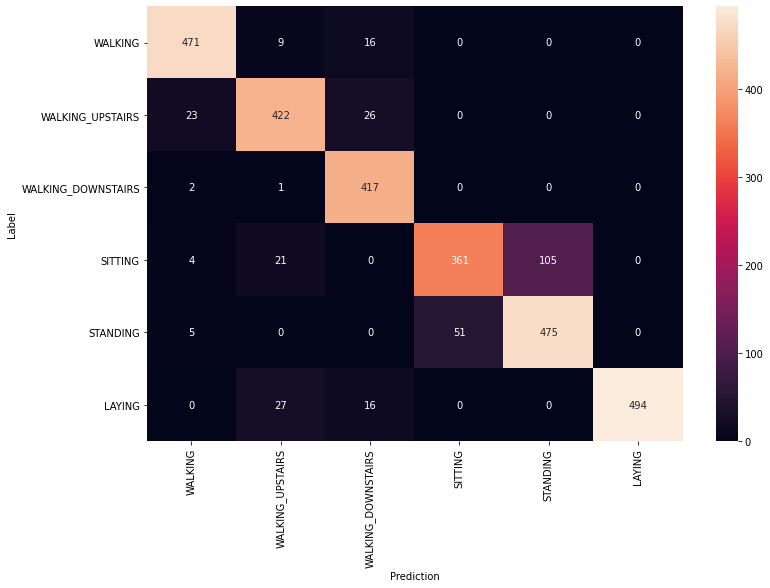

In [28]:
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
confusion_matrix = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()